In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

In [2]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [4]:
    king_all_copy, king_data= load_data('/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv')
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [46]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(180,22545): # 30
        x_train.append(king_train_norm[i-180:i])
        y_train.append(king_train_norm[i])
    for i in range(180, 1824):
        x_test.append(king_test["king"][i-180:i])
        y_test.append(king_test["king"][i])
        
    return x_train, y_train, x_test, y_test, king_test, king_training

In [64]:
x_train, y_train, x_test, y_test, king_test, king_training = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(np.min(x_train))
print(np.min(x_test))

(22545,)
(1824, 2)
0.0
0


In [17]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [29]:
def create_single_layer_rnn_model(x_train, y_train, x_test, king_training):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the RNN model
    model.fit(x_train, y_train, epochs=10, batch_size=64)

    print("predicting")
    # Finalizing predictions
    RNN_preds = model.predict(x_test)
    RNN_salmon_count = (RNN_preds * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)


    return model, RNN_salmon_count

In [19]:
def create_GRU_model(x_train, y_train, x_test, king_training):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape= (x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(x_train,y_train,epochs=10,batch_size=150)
    

    GRU_predicted_scaled = regressorGRU.predict(x_test)
    GRU_salmon_count = (GRU_predicted_scaled * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)

    return regressorGRU, GRU_salmon_count

In [41]:
print(x_train.shape)

(22364, 180, 1)


In [70]:
def simple_NN(x_train, y_train, x_test, king_training): 
    '''
    create a simple feedforward neural network trained on X_train
    and Y_train and make predictions on the X_test
    '''
    simpleNN = Sequential()
    simpleNN.add(Dense(10, activation='relu', input_shape= (x_train.shape[1],1)))
    simpleNN.add(Dense(1))
    simpleNN.compile(optimizer = 'adam', loss= 'mean_squared_error')

    # fit model 
    simpleNN.fit(x_train, y_train, epochs= 10, batch_size= 150)
    simpleNN_predicts = simpleNN.predict(x_test)

    # Denormalize 

    return simple_NN, simpleNN_predicts

In [20]:
# model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test)

In [22]:
regressorGRU, GRU_predicted_num = create_GRU_model(x_train, y_train, x_test, king_training)

Epoch 1/10
150/150 [==============================] - 34s 199ms/step - loss: 0.0027
Epoch 2/10
150/150 [==============================] - 31s 207ms/step - loss: 0.0019
Epoch 3/10
150/150 [==============================] - 34s 226ms/step - loss: 0.0014
Epoch 4/10
150/150 [==============================] - 39s 263ms/step - loss: 0.0011
Epoch 5/10
150/150 [==============================] - 31s 204ms/step - loss: 0.0010
Epoch 6/10
150/150 [==============================] - 30s 203ms/step - loss: 6.9957e-04
Epoch 7/10
150/150 [==============================] - 33s 218ms/step - loss: 6.7024e-04
Epoch 8/10
150/150 [==============================] - 38s 252ms/step - loss: 6.2205e-04
Epoch 9/10
150/150 [==============================] - 31s 209ms/step - loss: 5.9957e-04
Epoch 10/10
150/150 [==============================] - 31s 205ms/step - loss: 5.6919e-04


In [23]:
print(GRU_predicted_num)

[[203456]
 [203456]
 [203456]
 ...
 [   203]
 [   201]
 [   201]]


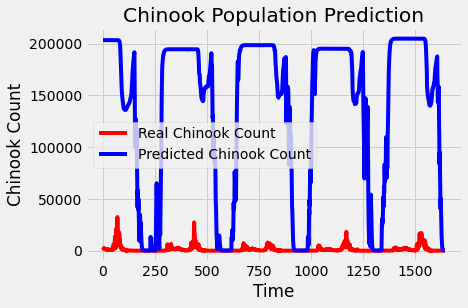

In [24]:
plot_predictions(y_test, GRU_predicted_num)

In [26]:
accuracy = accuracy_score(y_test, np.round(GRU_predicted_num.reshape(GRU_predicted_num.shape[0])))

In [27]:
accuracy

0.0

In [30]:
# test basic single layer RNN
model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test, king_training)

Epoch 1/10
350/350 [==============================] - 14s 36ms/step - loss: 9.5852e-04
Epoch 2/10
350/350 [==============================] - 12s 34ms/step - loss: 3.5986e-04
Epoch 3/10
350/350 [==============================] - 12s 34ms/step - loss: 3.1025e-04
Epoch 4/10
350/350 [==============================] - 11s 32ms/step - loss: 2.6257e-04
Epoch 5/10
350/350 [==============================] - 11s 31ms/step - loss: 2.7338e-04
Epoch 6/10
350/350 [==============================] - 11s 30ms/step - loss: 2.5864e-04
Epoch 7/10
350/350 [==============================] - 10s 30ms/step - loss: 2.6192e-04
Epoch 8/10
350/350 [==============================] - 10s 30ms/step - loss: 2.2772e-04
Epoch 9/10
350/350 [==============================] - 11s 30ms/step - loss: 2.7614e-04
Epoch 10/10
350/350 [==============================] - 11s 31ms/step - loss: 2.4042e-04
predicting


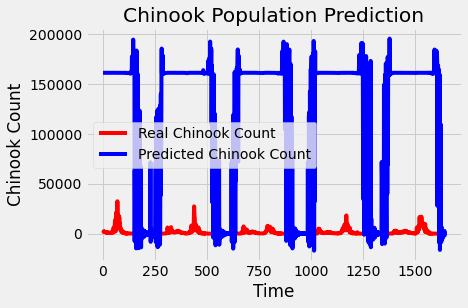

(1644, 1)


In [59]:
plot_predictions(y_test, test_preds)
print(test_preds.shape)

In [32]:
accuracy = accuracy_score(y_test, np.round(test_preds.reshape(test_preds.shape[0])))

In [33]:
accuracy

0.0

In [71]:
model, salmon_simpleNN = simple_NN(x_train, y_train, x_test, king_training)

Epoch 1/10
150/150 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 2/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 3/10
150/150 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 4/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 5/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 6/10
150/150 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 7/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 9/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 10/10
150/150 [==============================] - 0s 3ms/step - loss: 0.0023


In [72]:
test = (salmon_simpleNN * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)
print(test)
plot_predictions(y_test, test)

[[[  4167]
  [  3941]
  [  1495]
  ...
  [-41134]
  [-41134]
  [-41134]]

 [[  3941]
  [  1495]
  [  1495]
  ...
  [-41134]
  [-41134]
  [-41134]]

 [[  1495]
  [  1495]
  [  1495]
  ...
  [-41134]
  [-41134]
  [-41134]]

 ...

 [[-41134]
  [-41134]
  [-41134]
  ...
  [  1495]
  [  1495]
  [  1495]]

 [[-41134]
  [-41134]
  [-41134]
  ...
  [  1495]
  [  1495]
  [  1495]]

 [[-41134]
  [-41134]
  [-41134]
  ...
  [  1495]
  [  1495]
  [  1495]]]


ValueError: x and y can be no greater than 2-D, but have shapes (1644,) and (1644, 180, 1)